#Setup environment


In [5]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15303, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 15303 (delta 9), reused 11 (delta 1), pack-reused 15275
Receiving objects: 100% (15303/15303), 6.18 MiB | 19.48 MiB/s, done.
Resolving deltas: 100% (11123/11123), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.2 MB/s eta 0:00:00
  Pr

In [6]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [7]:
import os
import numpy as np
import cv2, os, json, random
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.model_zoo import get_config_file, get_checkpoint_url
import torch

torch.cuda.is_available()
setup_logger()

<Logger detectron2 (DEBUG)>

#load the google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#register the dataset

In [8]:
from detectron2.data.datasets import register_coco_instances
import json

# 註冊 train_dataset
register_coco_instances("train_dataset", {}, "/content/drive/MyDrive/DIP_final_project/MaskRCNN/training_dataset/train.json", "/content/drive/MyDrive/DIP_final_project/MaskRCNN/training_dataset/image/dictionary")

# 註冊 val_dataset
register_coco_instances("val_dataset", {}, "/content/drive/MyDrive/DIP_final_project/MaskRCNN/training_dataset/val.json", "/content/drive/MyDrive/DIP_final_project/MaskRCNN/training_dataset/image/dictionary")

#set the train model

In [9]:
# Configuration
cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))  # Default configuration
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Default pretrained weights
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 1000   # Adjust according to your dataset size
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Number of classes
cfg.SOLVER.OPTIMIZER = "Adam"
cfg.MODEL.DEVICE='cuda'

#set the output directory

In [10]:
cfg.OUTPUT_DIR = "/content/drive/MyDrive/DIP_final_project/MaskRCNN/output_model"

#start trainning

In [ ]:
# Training
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

model_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

#start valid

In [ ]:
# Configure the Model for Evaluation
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path to the model weights
cfg.DATASETS.TEST = ("val_dataset",)  # Validation dataset
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model

# Import Evaluation Modules
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Perform Evaluation
evaluator = COCOEvaluator("val_dataset", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "val_dataset")
inference_on_dataset(trainer.model, val_loader, evaluator)

[01/11 09:19:50 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [01/11 09:19:50 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [01/11 09:19:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/11 09:19:51 d2.data.datasets.coco]: Loaded 7 images in COCO format from /content/drive/MyDrive/DIP_final_project/MaskRCNN/training_dataset/val.json
[01/11 09:19:51 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   water    | 13           |
|            |              |
[01/11 09:19:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/11 09:19:51 d2.data.common]: Serializing t

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[01/11 09:19:54 d2.evaluation.evaluator]: Total inference time: 0:00:00.555319 (0.277659 s / iter per device, on 1 devices)
[01/11 09:19:54 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.147779 s / iter per device, on 1 devices)
[01/11 09:19:54 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/11 09:19:54 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/DIP_final_project/MaskRCNN/output_model/coco_instances_results.json
[01/11 09:19:55 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.641
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.825
 Average Precision  (AP) @[ IoU=0.

OrderedDict([('bbox',
              {'AP': 64.05091937765205,
               'AP50': 82.46110325318247,
               'AP75': 63.96039603960397,
               'APs': nan,
               'APm': 30.297029702970292,
               'APl': 75.36682239652538}),
             ('segm',
              {'AP': 47.86421499292787,
               'AP50': 71.1881188118812,
               'AP75': 45.81329561527581,
               'APs': nan,
               'APm': 16.83168316831683,
               'APl': 59.21163544925921})])

#random output one merged image

[01/11 09:19:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DIP_final_project/MaskRCNN/output_model/model_final.pth ...
WARNING [01/11 09:19:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/11 09:19:57 d2.data.datasets.coco]: Loaded 7 images in COCO format from /content/drive/MyDrive/DIP_final_project/MaskRCNN/training_dataset/val.json



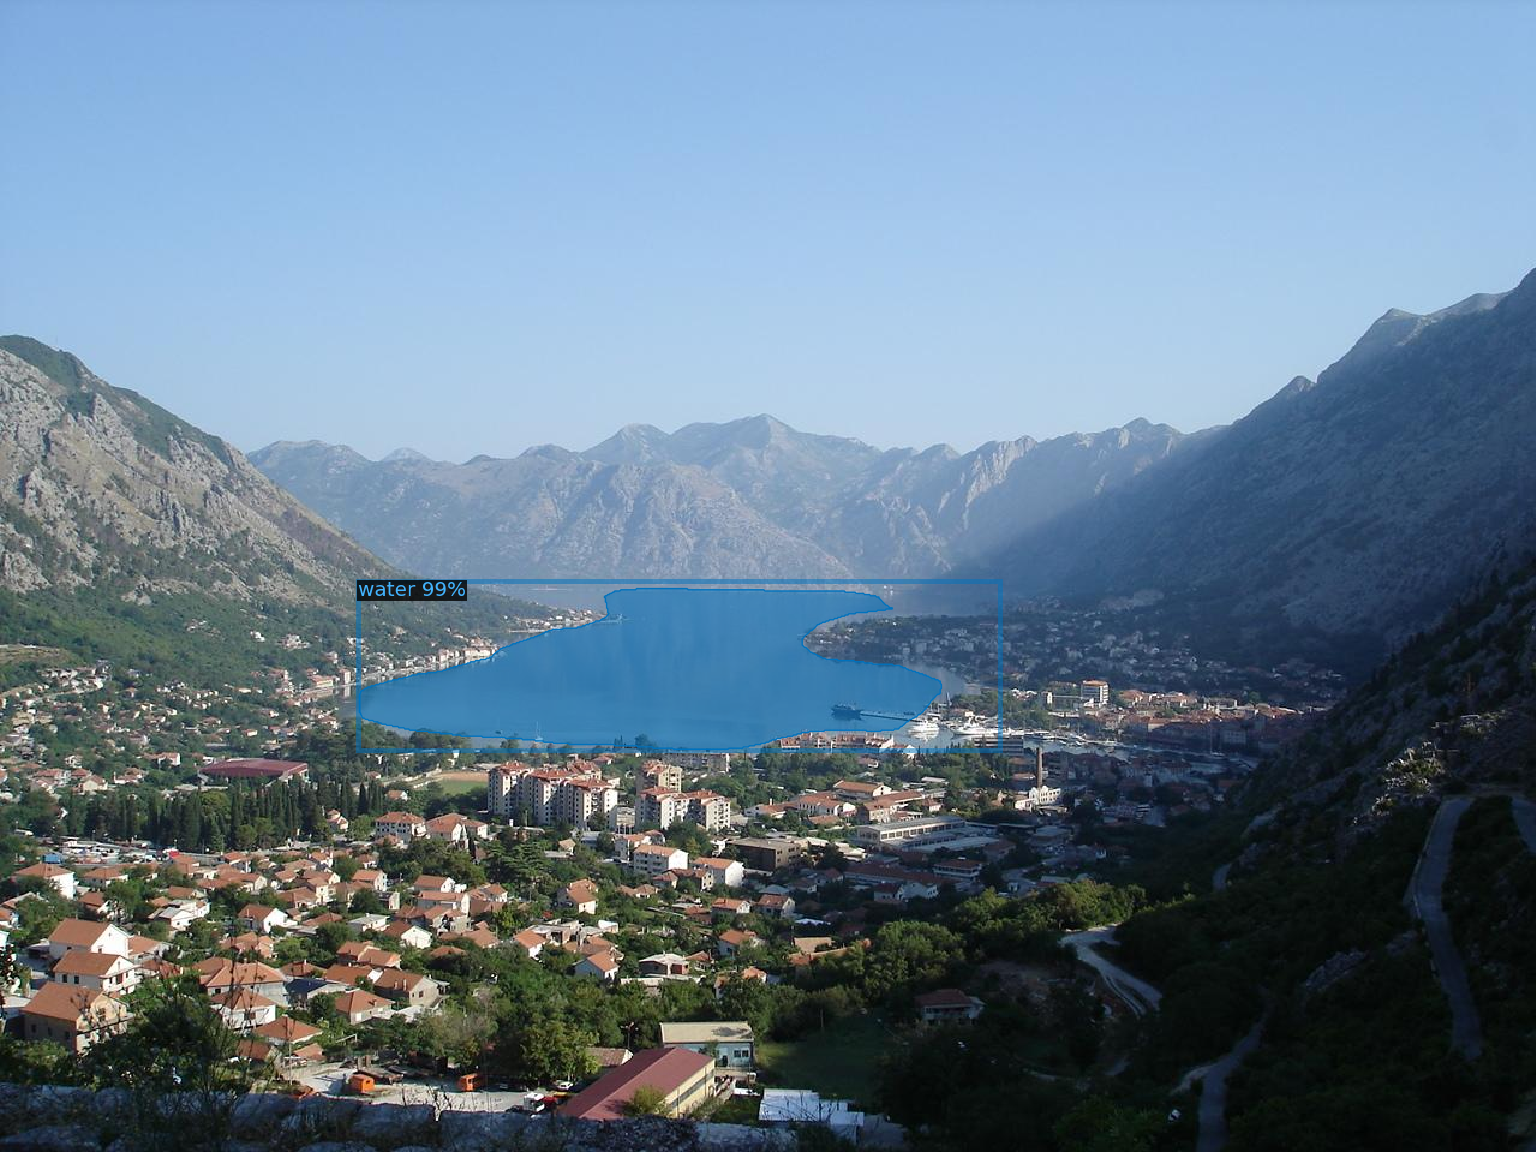

In [ ]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultPredictor
from google.colab.patches import cv2_imshow

# Configure the Model for Evaluation
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path to the model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
predictor = DefaultPredictor(cfg)

# Load the validation dataset
val_dataset_dicts = DatasetCatalog.get(cfg.DATASETS.TEST[0])
val_metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

folder_path = '/content/drive/MyDrive/DIP_final_project/MaskRCNN/training_dataset/image/dictionary'

# 生成一个介于1和60之间的随机整数
random_image_number = random.randint(1, 60)
selected_image_filename = f"{random_image_number}.jpg"
img_path = os.path.join(folder_path, selected_image_filename)
image = cv2.imread(img_path)
outputs = predictor(image)

# Visualize the prediction results
v = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

print()

# Display or save the result
cv2_imshow(out.get_image()[:, :, ::-1])
# cv2.waitKey(0)
# cv2.destroyAllWindows()


#save the metadata

In [ ]:
import json
from detectron2.data import MetadataCatalog

# 获取数据集的元数据
metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

# 将Metadata对象转换为字典
metadata_dict = metadata.as_dict()

# 指定保存元数据的文件路径
output_file_path = os.path.join(cfg.OUTPUT_DIR,"metadata.json")

# 将元数据保存到文件中
with open(output_file_path, 'w') as file:
    # 使用json.dump进行格式化写入
    json.dump(metadata_dict, file, indent=2)

print(f"Metadata saved to {output_file_path}")

Metadata saved to /content/drive/MyDrive/DIP_final_project/MaskRCNN/output_model/metadata.json


#save in mask_origin_merged image

In [ ]:
# 迴圈處理60張圖片並合併儲存masks
for i in range(1, 61):
    selected_image_filename = f"{i}.jpg"
    img_path = os.path.join(folder_path, selected_image_filename)
    image = cv2.imread(img_path)
    outputs = predictor(image)

    # 取得 instances 和 masks
    instances = outputs["instances"].to("cpu")
    masks = instances.get("pred_masks").numpy()

    # 若資料夾不存在，則建立用來儲存 masks 的資料夾
    merged_image_folder = '/content/drive/MyDrive/DIP_final_project/MaskRCNN/outputs_merged_image'
    os.makedirs(merged_image_folder, exist_ok=True)

    # 將多個 masks 合併
    merged_mask = np.zeros_like(masks[0], dtype=np.uint8)
    for mask in masks:
        merged_mask = np.logical_or(merged_mask, mask)

    # 設定 mask 的透明度為 0.5
    merged_mask_alpha = (merged_mask * 0.8 * 255).astype('uint8')

    # 合成原圖和 mask
    result = cv2.addWeighted(image, 1, np.stack([merged_mask_alpha] * 3, axis=-1), 0.5, 0)

    # 儲存合併後的圖像
    result_filename = f"{i}_merged_image.jpg"
    result_path = os.path.join(merged_image_folder, result_filename)
    cv2.imwrite(result_path, result)

print("Merged mask images saved successfully.")


Merged mask images saved successfully.


#save in mask

In [ ]:
# 迴圈處理60張圖片並儲存 masks
for i in range(1, 61):
    selected_image_filename = f"{i}.jpg"
    img_path = os.path.join(folder_path, selected_image_filename)
    image = cv2.imread(img_path)
    outputs = predictor(image)

    # 取得 instances 和 masks
    instances = outputs["instances"].to("cpu")
    masks = instances.get("pred_masks").numpy()

    # 若資料夾不存在，則建立用來儲存 masks 的資料夾
    mask_folder = '/content/drive/MyDrive/DIP_final_project/MaskRCNN/outputs_mask'
    os.makedirs(mask_folder, exist_ok=True)

    # 將多個 masks 合併
    merged_mask = np.zeros_like(masks[0], dtype=np.uint8)
    for mask in masks:
        merged_mask = np.logical_or(merged_mask, mask)

    # 儲存合併後的 mask
    mask_filename = f"{i}_mask.jpg"
    mask_path = os.path.join(mask_folder, mask_filename)
    cv2.imwrite(mask_path, (merged_mask * 255).astype('uint8'))

    # 只針對第一張圖片顯示預測結果
    if i == 1:
        v = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=1.2)
        out = v.draw_instance_predictions(instances)
        cv2_imshow(out.get_image()[:, :, ::-1])

print("Masks saved successfully.")


Output hidden; open in https://colab.research.google.com to view.